In [60]:
from import_library import *

In [61]:
data_path = 'data/'
savePath = 'Results/'

# Data Injection

In [64]:
def convert_percentage_object_2_float(input):
    '''    
    Convert objects value to float ones , using in DataFrame transformation
    ----------
    Attributes:
    input: input data
    ----------
    Example:
    data['OCB_pct'] = data['OCB_pct'].apply(TransformCommaToColons)
    '''    
    return float(input.replace('%',''))

def read_file_csv(file):
    '''   
    Read csv file 
    ----------
    Attributes:
    file: file
    ----------
    Example:
    ocb_file = 'OCB Historical Data.csv'
    ocb_data = read_file_csv(ocb_file)
    '''
    data = pd.read_csv(data_path + file, sep=',',header = 0)
    data['Change %'] = data['Change %'].apply(convert_percentage_object_2_float)    
    return data

def convert_percentage_object_2_float(input):
    '''    
    Convert objects value to float ones , using in DataFrame transformation
    ----------
    Attributes:
    input: input data
    ----------
    Example:
    data['OCB_pct'] = data['OCB_pct'].apply(TransformCommaToColons)
    '''    
    return float(input.replace('%',''))

def data_wrangling(data_path, save=False):
    '''    
    Transforming and structuring data from one raw form into a desired format
    Only rate of change(ROC) is considered in this function
    ----------
    Attributes:
    data_path: data path
    ----------
    Example:
    data = data_wrangling(data_path)
    '''    
    all_names = os.listdir(data_path) # list all name in a folder
    data = pd.DataFrame()
    stock_names = []
    for name in all_names:
        if name[:2] == 'VN' or name[-3:] != 'csv':
            continue
        data_temp = read_file_csv(name)        
        data_temp = data_temp['Change %']
        data_temp.rename(f'{name[:3]}',inplace=True)
        data = pd.concat([data,data_temp],axis=1)
        stock_names.append(f'{name[:3]}')
     
    if save:
        title = 'stock.csv'
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')  
        data.to_csv(f'{savePath}/{title}')    
    
    return data,stock_names

In [65]:
data, stock_names = data_wrangling(data_path)
data

,KHP,OCB,BMI,POW,SBT
0,0.11,-0.73,1.18,-0.44,-0.74
1,0.00,-0.73,-1.86,-1.72,-2.53
2,-0.22,-0.36,0.00,-0.43,0.36
3,0.00,0.73,1.42,0.43,0.73
4,-1.07,-0.72,-1.40,0.00,-1.44
...,...,...,...,...,...
699,-0.14,-1.87,0.20,1.20,0.00
700,0.00,5.16,4.55,6.87,6.96
701,1.15,3.30,2.54,1.30,6.85
702,-1.55,0.51,-6.35,-3.36,-6.67


In [66]:
def market_data_generation(data_path):
    market_file = 'VN Index Historical Data.csv'
    market_data = read_file_csv(market_file)
    market_data = market_data['Change %']
    return market_data

In [67]:
market_data = market_data_generation(data_path)
market_data

0      0.65
1     -2.27
2      0.30
3      0.62
4      0.22
       ... 
699    0.08
700    3.32
701    3.86
702   -2.00
703    3.19
Name: Change %, Length: 704, dtype: float64

# Correlation Analysis

In [109]:
def correlation_matrix(df,features,title=None,save=False):
    '''    
    Plot Correlation Matrix
    ----------
    Attributes:
    df : pd.DataFrame                
    features: list
        list of features of the df_dataset
    title: str, default: None
        The name of saved file
    save: bool, default: False
        save or not
    ----------
    Example:
    CorrelationMatrix(df_smoothed_scaled_filterd_dataset,orderedFeatured,title=None,save=False)
    '''    
    plt.close('all')
    train = df[features]
    plt.figure(figsize=(15, 15))
    dataplot = sb.heatmap(train.corr(), xticklabels=train.corr().columns, yticklabels=train.corr().columns,  cmap="YlGnBu", annot=True)
    if title == None:
        title = 'corr.png'    
    if save:
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')  
        plt.savefig(f'{savePath}/{title}', bbox_inches="tight")    
    plt.show()

In [110]:
data

,KHP,OCB,BMI,POW,SBT
0,0.11,-0.73,1.18,-0.44,-0.74
1,0.00,-0.73,-1.86,-1.72,-2.53
2,-0.22,-0.36,0.00,-0.43,0.36
3,0.00,0.73,1.42,0.43,0.73
4,-1.07,-0.72,-1.40,0.00,-1.44
...,...,...,...,...,...
699,-0.14,-1.87,0.20,1.20,0.00
700,0.00,5.16,4.55,6.87,6.96
701,1.15,3.30,2.54,1.30,6.85
702,-1.55,0.51,-6.35,-3.36,-6.67


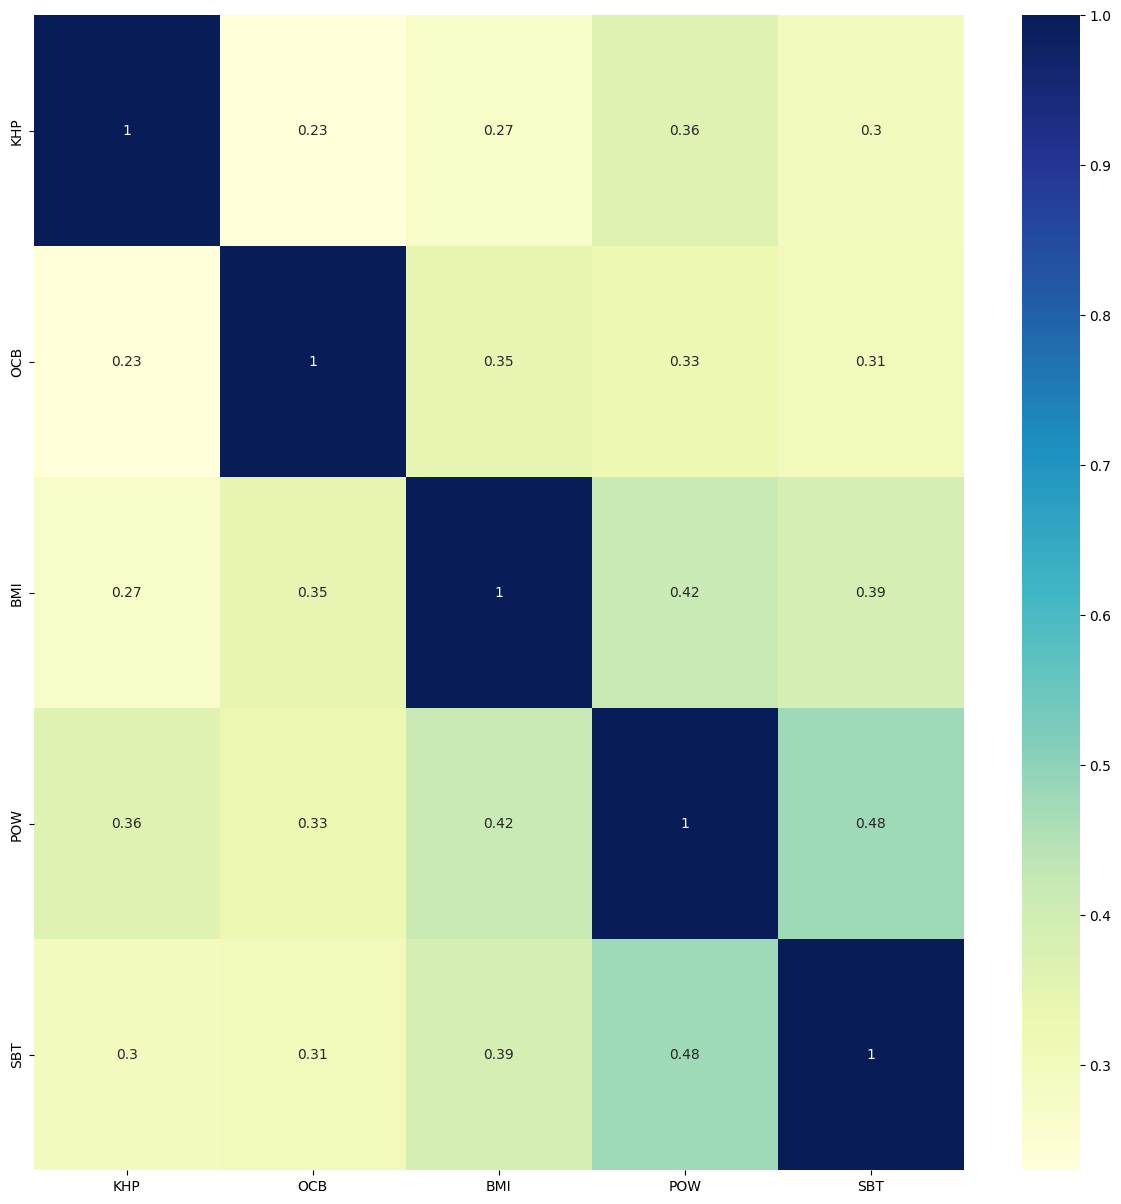

In [108]:
selected_columns = data.columns
correlation_matrix(data,selected_columns) 
# Date and OCB (-0.58)
# OCB and BMM (0.82) 
# KHP and OCB (0.45)
# KHP and BMI (0.63)

# Beta Computation

In [68]:
def beta_computation(data,market_data,save=False):
    beta = []
    Var = np.var(market_data, ddof =1 )
    for i in range(len(data.columns)):
        # beta = cov(r_stock_i,r_market)/Var(r_market)
        CovarMat = np.cov(market_data,data.iloc[:,i])
        Covar = CovarMat[1,0] # Take out Cov
        beta.append(Covar/Var)
    
    dict_beta = {
        'stocks' : data.columns,
        'beta': beta
    }
    beta_result_df = pd.DataFrame(dict_beta)
    if save:
        title = 'beta_computation.csv'
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')  
        beta_result_df.to_csv(f'{savePath}/{title}',index=False)
    return beta_result_df

In [70]:
beta_result_df = beta_computation(data,market_data)
beta_result_df

,stocks,beta
0,KHP,0.85
1,OCB,1.07
2,BMI,1.16
3,POW,1.25
4,SBT,1.17


# Compute Portfolio Risk, Expected Portfolio Return, Portfolio Beta

In [16]:
# Assume as weights of stocks as [0.5, 0.3, 0.2]
weights = np.array([0.5,0.3,0.2])

In [17]:
# Compute mean and cov of asset returns
mean_return = np.mean(data,axis=0)
cov_return = np.cov(data,rowvar=False) # convert each columns --> variables while rows-->observation

In [18]:
# Compute portfolio risk  ([1,3]x[3,3])x[3,1]
port_risk = np.matmul(np.matmul(weights,cov_return), np.transpose(weights))
port_risk

3.668847550318035

In [19]:
# Annualized - len(data) - the number of trading days of a year (251days)
annualized_riks = np.sqrt(port_risk*251) #30.34
annualized_riks

30.34601679182668

In [20]:
# expected portfolio return
portfolio_return = np.matmul(np.array(mean_return),weights.T) # 4.92%
# portfolio retrun
annualized_return = 251*np.array([portfolio_return])[0] # 12.37
# portfolio beta
portfolio_beta = np.matmul(beta,weights.T) # 0.456 
# --> follow the market movement and less volatile than market

# Portfolio Clusters

In [81]:
def port_cluster(data,stock_names,save = False):
    '''    
    Portfolio clustering
    ----------
    Attributes:
    data : df.DataFrame
        stock data
    stock_names: list
        stock names
    ----------
    Returns:
    df : df.DataFrame
        dataframe before clustering
    ----------
    Example:
    port_cluster(data, stock_names, save = True)
    '''
    from sklearn.cluster import KMeans
    mean_returns = pd.DataFrame(np.mean(data,axis=0),columns=['means'])
    cov_returns = np.cov(data, rowvar = False) # convert each columns --> variables while rows-->observation
    cov_returns_df = pd.DataFrame(cov_returns,columns = stock_names, index = stock_names)
    df = pd.concat([mean_returns, cov_returns_df],axis = 1)

    asset_cluster = KMeans(algorithm='auto', max_iter=600, n_clusters = 3)
    asset_cluster.fit(df)
    assets = np.array(stock_names)
    centroids = asset_cluster.cluster_centers_
    labels = asset_cluster.labels_
    for i in range(len(centroids)):
        print('Cluster', i+1)
        clt = np.where(labels == i)
        assetCluster = assets[clt]
        print(assetCluster)
        
    if save:
        title = 'cluster.txt'
        # Save best sold items
        with open(f'{savePath}/{title}', 'w') as fp:
            for i in range(len(centroids)):                
                clt = np.where(labels == i)
                assetCluster = assets[clt]
                fp.write(f'Cluster: {i+1}\n')
                fp.write(f'{assetCluster}') 
    return df

In [82]:
port_cluster(data, stock_names, save = False)

Cluster 1
['BMI' 'POW' 'SBT']
Cluster 2
['KHP']
Cluster 3
['OCB']


In [161]:
mean_returns = pd.DataFrame(np.mean(data,axis=0),columns=['means'])
cov_returns = np.cov(data,rowvar=False) # convert each columns --> variables while rows-->observation
cov_returns_df = pd.DataFrame(cov_returns,columns= stock_names, index = stock_names)
df = pd.concat([mean_returns, cov_returns_df],axis = 1)
df

,means,KHP,OCB,BMI,POW,SBT
KHP,0.09,7.45,1.58,1.91,2.53,2.22
OCB,0.02,1.58,6.31,2.25,2.09,2.12
BMI,0.06,1.91,2.25,6.69,2.77,2.77
POW,0.03,2.53,2.09,2.77,6.52,3.36
SBT,0.00,2.22,2.12,2.77,3.36,7.55


In [153]:
from sklearn.cluster import KMeans

In [157]:
asset_cluster = KMeans(algorithm='auto', max_iter=600, n_clusters = 3)
asset_cluster.fit(df)
centroids = asset_cluster.cluster_centers_
labels = asset_cluster.labels_
labels

array([2, 0, 1, 1, 1], dtype=int32)

In [158]:
# Fixing asset labels to cluster points 
# assets = np.array(labels)
assets = np.array(stock_names)
for i in range(len(centroids)):
    print('Cluster', i+1)
    clt = np.where(labels == i)
    assetCluster = assets[clt]
    print(assetCluster)

Cluster 1
['OCB']
Cluster 2
['BMI' 'POW' 'SBT']
Cluster 3
['KHP']


# Mean- Variance Optimization 
Maximize mean (return)   
Minimize variance (portfolio risk)

In [174]:
portfolio_size = len(stock_names)

In [326]:
def max_returns(mean_returns, portfolio_size):
    '''    
    Maximial Expected Returns (reference)
    ----------
    Attributes:
    mean_returns: 
    portfolio_size: 
    ----------
    Example:
    mean_returns = pd.DataFrame(np.mean(data,axis=0),columns=['means'])
    portfolio_size = len(stock_names)
    res = max_returns(mean_returns,portfolio_size)
    res.x # get optimal value

    Additional:
    min x : c.T @ x --> Minimize
    A_ub @ x <= b_ub ---> inequality constrains
    A_eq @ x = A_ub --> equality constrains
    l<= x <= u (boudary)    
    '''  
    from scipy.optimize import linprog
    c = (np.multiply(-1,mean_returns))
    A = np.ones([portfolio_size,1]).T # weights 
    b = [1] 
    # minimize a linear objective function subject 
    # to linear equality and inequality constraints (of negative function --> max)
    res = linprog(c, # Minimize of negative mean_returns --> maximize
                  A_ub = A,  # (1,5)x(5,1) <= b --> sum of weights < =1 
                  b_ub = b,   #
                  bounds =(0,1),  # weights in range (0,1)
                  method = 'simplex')
    return res

def min_risk_port(cov_returns, portfolio_size):
    '''    
    Minimize risk portfolio
    ----------
    Attributes:
    mean_returns: 
    cov_returns: 
    ----------
    Example:    
    portfolio_size = len(stock_names)
    cov_returns = np.cov(data,rowvar=False) 
    opt = min_risk_port(cov_returns, portfolio_size) 
    opt.x  
    '''  
    from scipy import optimize
    def f(x,cov_returns):
        # typical second orders 
        func = np.matmul(np.matmul(x,cov_returns),x.T)
        return func

    def constraint_eq(x):
        A = np.ones(x.shape)
        b = 1
        # A@ x.T - 1
        constrant_val = np.matmul(A,x.T) - b
        return constrant_val

    x_init = np.repeat(0.1, portfolio_size)
    cons = ({
        'type' : 'eq',
        'fun': constraint_eq,
    })
    lb = 0
    ub =1 
    bnds = tuple([(lb,ub) for x in x_init])
    opt = optimize.minimize(f,
                             x0 = x_init,
                             args = (cov_returns),
                             bounds = bnds,# 0-1
                             constraints = cons, # Sum of weights - 1 =0 
                             tol = 10**-3,
                            )
    return opt

def min_risk_constraint(mean_returns,cov_returns,portfolio_size, R=0.06):
    '''    
    Minimal risk and Maximum return portfolios
    ----------
    Attributes:
    mean_returns: 
    cov_returns: 
    portfolio_size:
    R : value of inequality constraint
    ----------
    Example:    
    portfolio_size = len(stock_names)
    cov_returns = np.cov(data,rowvar=False)     
    opt = min_risk_constraint(mean_returns, cov_returns, portfolio_size, 0.06)
    opt.x
    '''  
    from scipy import optimize
    def f(x,cov_returns):
        # typical second orders  - main function - 
        func = np.matmul(np.matmul(x,cov_returns),x.T)
        return func

    def constraint_eq(x):
        # A@x - B = 0 
        # sum of weights =1 
        A_eq = np.ones(x.shape)
        b_eq = 1
        # A@ x.T - 1 = 0
        eq_constrant_val = np.matmul(A_eq,x.T) - b_eq
        return eq_constrant_val

    def constrain_ineq(x, mean_returns, R):
        # A@x >= R
        # func >= b 
        # max expected return
        A_ineq = np.array(mean_returns).T
        b_ineq = R
        Ineq_constrant_val =  np.matmul(A_ineq,x) - b_ineq
        return Ineq_constrant_val

    x_init = np.repeat(0.1, portfolio_size)
    cons = (
        {'type' : 'eq', 'fun': constraint_eq},
        {'type' : 'ineq', 'fun': constrain_ineq,'args':(mean_returns,R)},
    )
    # x boundarys
    lb = 0
    ub = 1 
    bnds = tuple([(lb,ub) for x in x_init])
    # Main optimizing procedure
    opt = optimize.minimize(f,
                             x0 = x_init,
                             args = (cov_returns),
                             method = 'trust-constr',
                             bounds = bnds,# 0-1
                             constraints = cons, # Sum of weights - 1 =0 
                             tol = 10**-3,
                            )
    return opt

In [385]:
# maximal expected portfolio return computation for the k-portfolio
result1 = max_returns(mean_returns,portfolio_size)
max_return_weights = result1.x
max_exp_port_return = np.matmul( np.array(mean_returns).T,max_return_weights)
print(f'Maximal Expected Portfolio Return: {max_exp_port_return[0]:.3f}')

# Expected portfolio return computation for the minium risk k-portfolio
result2 = min_risk_port(cov_returns,portfolio_size)
min_risk_weights = result2.x
min_risk_port_return = np.matmul( np.array(mean_returns).T,min_risk_weights)
print(f'Expected Return of Minium Risk Portfolio: {min_risk_port_return[0]:.3f}')

# Compute efficient set for maximum return and minium risk porfolios
increment = 0.001 
low = min_risk_port_return
high = max_exp_port_return

# iniitialize optimal weight set and risk-return point set
x_optimal = []
min_risk_point = []
ex_port_return_point = []

# repeated execution of function min_risk_constraint to determine the efficient set
while (low < high):
    result3 = min_risk_constraint(mean_returns, cov_returns, portfolio_size, low)
    x_optimal.append(result3.x)
    ex_port_return_point.append(low)
    low = low +  increment

#gather optimal weight set    
x_optimal_array = np.array(x_optimal)

Maximal Expected Portfolio Return: 0.091
Expected Return of Minium Risk Portfolio: 0.042


In [387]:

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251
min_risk_point = np.diagonal(np.matmul((np.matmul(x_optimal_array,cov_returns)),\
                                     np.transpose(x_optimal_array)))
risk_point =   np.sqrt(min_risk_point*251) 

#obtain expected portfolio annualized return for the 
#efficient set portfolios, for trading days = 251
ret_point = 251*np.array(ex_port_return_point) 

#display efficient set portfolio parameters
print("Size of the  efficient set:", x_optimal_array.shape )
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[risk_point, ret_point])
                  

Size of the  efficient set: (49, 5)
Annualized Risk and Return of the efficient set portfolios: 
 [[28.35760854 10.60987383]
 [28.38098673 10.86087383]
 [28.38859357 11.11187383]
 [28.41874499 11.36287383]
 [28.4460307  11.61387383]
 [28.47976291 11.86487383]
 [28.52210764 12.11587383]
 [28.58269814 12.36687383]
 [28.65286273 12.61787383]
 [28.73266729 12.86887383]
 [28.83492161 13.11987383]
 [28.91911986 13.37087383]
 [29.04754013 13.62187383]
 [29.17910202 13.87287383]
 [29.29273912 14.12387383]
 [29.41041844 14.37487383]
 [29.54960847 14.62587383]
 [29.71881997 14.87687383]
 [29.87559959 15.12787383]
 [30.06984532 15.37887383]
 [30.21300152 15.62987383]
 [30.43231535 15.88087383]
 [30.63916236 16.13187383]
 [30.86072697 16.38287383]
 [31.09448659 16.63387383]
 [31.3374627  16.88487383]
 [31.59321994 17.13587383]
 [31.86046087 17.38687383]
 [32.13945021 17.63787383]
 [32.42043706 17.88887383]
 [32.72632949 18.13987383]
 [33.04403194 18.39087383]
 [33.27066496 18.64187383]
 [33.681181

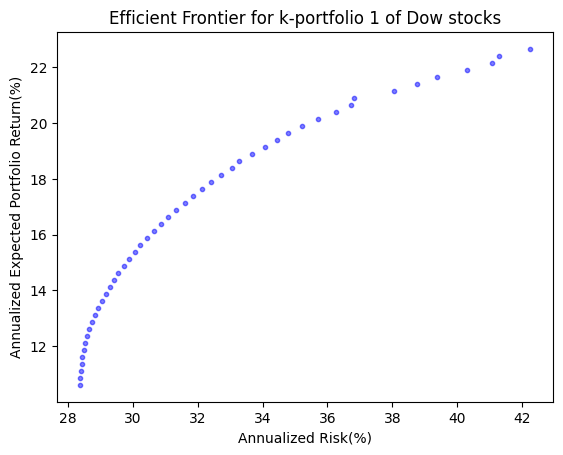

In [388]:
#Graph Efficient Frontier
import matplotlib.pyplot as plt

NoPoints = risk_point.size

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for k-portfolio 1 of Dow stocks')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(risk_point, ret_point, s=area, c=colours, alpha =0.5)
plt.show()

In [453]:
expected_annualized_risk = 32 # Input from external
idx = np.where((risk_point > expected_annualized_risk) & (risk_point< expected_annualized_risk+1))[0][0]
print(f'Stocks: {stock_names}')
print(f'Optimal weight: {np.round(x_optimal_array[idx],3)}')
print(f'Annualized Risk: {risk_point[idx]:.2f} \nReturn of the efficient set portfolios: {ret_point[idx][0]:.2f}')

Stocks: ['KHP', 'OCB', 'BMI', 'POW', 'SBT']
Optimal weight: [0.54  0.104 0.332 0.021 0.003]
Annualized Risk: 32.14 
Return of the efficient set portfolios: 17.64


# Sharpe Ratio Optimization

In [470]:
def max_sharpe_ratio_opt(mean_returns, cov_returns, risk_free_rate, portfolio_size):
    '''    
    Maximizing Sharpe Ratio --> compensate the risk_free
    ----------
    Attributes:
    mean_returns: 
    cov_returns: 
    risk_free_rate: daily risk rate return
    portfolio_size:
    
    ----------
    Example:    
    Rf = 2.85
    r0 = (np.power((1 + Rf/100 ),  (1.0 / 360.0)) - 1.0) * 100 
    shapre_result = max_sharpe_ratio_opt(mean_returns, cov_returns, r0, portfolio_size)
    '''  
    from scipy import optimize 
    # define maximization of Sharpe Ratio using principle of duality
    def  f(x, mean_returns, cov_returns, risk_free_rate, portfolio_size):
        func_num = np.matmul(np.array(mean_returns).T,x)- risk_free_rate
        func_den = np.sqrt(np.matmul(np.matmul(x, cov_returns), x.T) )        
        func = -(func_num / func_den)
        return func

    #define equality constraint representing fully invested portfolio
    def constraint_eq(x):
        A = np.ones(x.shape)
        b = 1 
        constraint_val = np.matmul(A,x.T)-b 
        return constraint_val
    
    
    #define bounds and other parameters
    x_init=np.repeat(0.33, portfolio_size)
    cons = ({'type': 'eq', 'fun':constraint_eq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in x_init])
    
    #invoke minimize solver
    opt = optimize.minimize (f, 
                             x0 = x_init, 
                             args = (mean_returns,cov_returns,risk_free_rate, portfolio_size), method = 'SLSQP',
                             bounds = bnds, 
                             constraints = cons, 
                             tol = 10**-3,
                            )    
    return opt

In [ ]:
# 3% -> annual risk free
Rf = 2.85
r0 = (np.power((1 + Rf/100 ),  (1.0 / 360.0)) - 1.0) * 100 

#initialization
x_opt =[]
min_risk_point = []
exp_port_return_point =[]
max_sharpe_ratio = 0

#compute maximal Sharpe Ratio and optimal weights
shapre_result = max_sharpe_ratio_opt(mean_returns, cov_returns, r0, portfolio_size)
x_opt.append(shapre_result.x)

#compute risk returns and max Sharpe Ratio of the optimal portfolio   
x_opt_array = np.array(x_opt)
risk = np.matmul((np.matmul(x_opt_array,cov_returns)), np.transpose(x_opt_array))
exp_return = np.matmul(np.array(mean_returns).T,x_opt_array.T)
ann_risk =   np.sqrt(risk*251) 
ann_ret = 251*np.array(exp_return) 
max_sharpe_ratio = (ann_ret-Rf)/ann_risk 

In [479]:
#display results
print('Maximal Sharpe Ratio: ', max_sharpe_ratio, '\nAnnualized Risk (%):  ', \
      ann_risk, '\nAnnualized Expected Portfolio Return(%):  ', ann_ret)
print('\nOptimal weights (%):\n',  x_opt_array*100 )

Maximal Sharpe Ratio:  [[0.26326572]] 
Annualized Risk (%):   [[28.60531319]] 
Annualized Expected Portfolio Return(%):   [[10.38079831]]

Optimal weights (%):
 [[21.75706756 19.54424407 20.53042942 19.54416112 18.62409784]]


# Constrained Portforlio Optimization
Consider low and high volatility

In [483]:
beta_result_df # KHP - high - the rest -> low

,stocks,beta
0,KHP,1.00
1,OCB,0.21
2,BMI,0.26
3,POW,0.34
4,SBT,0.30


In [484]:
beta

[0.9999999999999999,
 0.21156212447108114,
 0.25574143914802067,
 0.33983922817209095,
 0.29800142000087537]

In [505]:
#function to handle bi-criterion portfolio optimization with constraints

#dependencies
import numpy as np
from scipy import optimize 

def bi_criterion_func_opt(mean_returns, cov_returns, risk_avers_param, portfolio_size):
       
    def  f(x, mean_returns, cov_returns, risk_avers_param, portfolio_size):
        # Combine 2 objective function by larange transformation
        port_var = np.matmul(np.matmul(x, cov_returns), x.T) 
        port_exp_ret = np.matmul(np.array(mean_returns).T,x.T)
        func = risk_avers_param * port_var - (1 - risk_avers_param)*port_exp_ret
        return func

    def constraint_eq(x):
        A=np.ones(x.shape)
        b=1
        constraint_val = np.matmul(A,x.T)-b 
        return constraint_val
    # Combine 2 inequality function 
    # 0.01 <= sum(Weights of low Volativity) <= 0.6
    # 0.01 <= sum(Weights of high Volativity) <= 0.4
    
    def constraint_ineq_up_bounds(x):
        # beta >1 --> 1 - down line -->0
        A = [[1,0,0,0,0], [0,1,1,1,1]]
        b_up_bounds =np.array([0.6,0.4]).T
        constraint_val_up_bounds = b_up_bounds - np.matmul(A,x.T) 
        return constraint_val_up_bounds

    def constraint_Ineq_low_bounds(x):
        # inq : func >=0
        A = [[1,0,0,0,0], [0,1,1,1,1]]
        b_low_bounds =np.array([0.01, 0.01]).T
        constraint_val_low_bounds = np.matmul(A,x.T)- b_low_bounds  
        return constraint_val_low_bounds
    
    x_init=np.repeat(0.01, portfolio_size)
    cons = ({'type': 'eq', 'fun':constraint_eq}, \
            {'type':'ineq', 'fun': constraint_ineq_up_bounds},\
            {'type':'ineq', 'fun': constraint_Ineq_low_bounds})
    bnds = [(0,0.1),(0.,1),(0.,1),(0.,1),(0.,1)]

    opt = optimize.minimize (f, 
                             x0 = x_init, 
                             args = ( mean_returns, cov_returns,risk_avers_param, portfolio_size),
                             method = 'SLSQP',  
                             bounds = bnds, 
                             constraints = cons,
                             tol = 10**-3)
    return opt

In [506]:
#obtain optimal portfolios for the constrained portfolio optimization model
#Maximize returns and Minimize risk with fully invested, bound and 
#class constraints

#initialization
x_opt =[]
min_risk_point = []
exp_port_return_point =[]



for points in range(0,60):
    risk_avers_param = points/60.0
    result = bi_criterion_func_opt(mean_returns, cov_returns, risk_avers_param, portfolio_size)
    x_opt.append(result.x)

#compute annualized risk and return  of the optimal portfolios for trading days = 251  
x_opt_array = np.array(x_opt)
min_risk_point = np.diagonal(np.matmul((np.matmul(x_opt_array,cov_returns)),\
                                     np.transpose(x_opt_array)))
risk_point =   np.sqrt(min_risk_point*251) 
exp_port_return_point= np.matmul(x_opt_array, mean_returns )
ret_point = 251*np.array(exp_port_return_point) 

#display optimal portfolio results
#display efficient set portfolio parameters
print("Size of the  efficient set:", x_optimal_array.shape )
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[risk_point, ret_point])
                  

Size of the  efficient set: (49, 5)
Annualized Risk and Return of the efficient set portfolios: 
 [[18.04806796  7.86371591]
 [15.60379631  6.87884958]
 [14.72343589  6.27375377]
 [14.47670261  5.94614658]
 [14.33659301  5.72570739]
 [14.27979064  5.59566948]
 [14.24941384  5.5090099 ]
 [14.23139113  5.44706277]
 [14.21991253  5.40064786]
 [14.21217696  5.36449566]
 [14.20675404  5.33559934]
 [14.20282008  5.31195732]
 [14.20504067  5.29369231]
 [14.19764193  5.27550193]
 [14.19591582  5.26129456]
 [14.19455239  5.24898153]
 [14.19344227  5.23802091]
 [14.19255826  5.22851258]
 [14.19183019  5.22001305]
 [14.19128573  5.21245793]
 [14.19072724  5.2055647 ]
 [14.19030646  5.19937253]
 [14.18995098  5.19374331]
 [14.18964919  5.18860863]
 [14.18939082  5.18389163]
 [14.19623742  5.18156325]
 [14.18897849  5.17555658]
 [14.18881335  5.17185172]
 [14.18867006  5.16841318]
 [14.18854499  5.16520395]
 [14.18843621  5.1622198 ]
 [14.18834081  5.15942252]
 [14.1882572   5.15680152]
 [14.188183

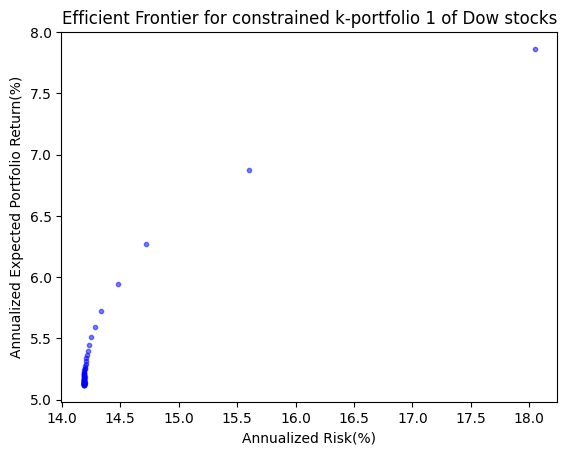

In [513]:
import matplotlib.pyplot as plt

#Graph Efficient Frontier for the constrained portfolio model
NoPoints = risk_point.size

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for constrained k-portfolio 1 of Dow stocks')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(risk_point, ret_point, s=area, c=colours, alpha =0.5)
plt.show()

In [514]:
expected_annualized_risk = 14 # Input from external
idx = np.where((risk_point > expected_annualized_risk) & (risk_point< expected_annualized_risk+0.5))[0][0]
print(f'Stocks: {stock_names}')
print(f'Optimal weight: {np.round(x_opt_array[idx],3)}')
print(f'Annualized Risk: {risk_point[idx]:.2f} \nReturn of the efficient set portfolios: {ret_point[idx][0]:.2f}')

Stocks: ['KHP', 'OCB', 'BMI', 'POW', 'SBT']
Optimal weight: [0.1   0.128 0.166 0.09  0.016]
Annualized Risk: 14.48 
Return of the efficient set portfolios: 5.95
